In [21]:
# Required Imports
import os, json, time
from pyproj import Geod    
from wildfire.Reader import Reader as WFReader
import geojson
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)


PER_YEAR_INPUT_PATH = output_paths.get('smoke_impacts_per_year_csv')

In [18]:
per_year_df = pd.read_csv(PER_YEAR_INPUT_PATH)

In [19]:
# Display the column headers and basic information for the politician dataset
print("\nPer Year Smoke Imact + Acres Burned - Column Headers:")
print(per_year_df.columns)

print("\nPer Year Smoke Imact + Acres Burned - Basic Info:")
print(per_year_df.info())

print("\nPer Year Smoke Imact + Acres Burned - First 5 Rows:")
print(per_year_df.head())


Per Year Smoke Imact + Acres Burned - Column Headers:
Index(['year', 'total_weighted_smoke_impact', 'total_acres_burned'], dtype='object')

Per Year Smoke Imact + Acres Burned - Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         61 non-null     int64  
 1   total_weighted_smoke_impact  61 non-null     float64
 2   total_acres_burned           61 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.6 KB
None

Per Year Smoke Imact + Acres Burned - First 5 Rows:
   year  total_weighted_smoke_impact  total_acres_burned
0  1961                     0.000000            0.000000
1  1962                     0.000000            0.000000
2  1963                     0.000000            0.000000
3  1964                     0.000256           28.468121
4  1965                 

In [23]:
# Constants
CITY_LOCATIONS = {
    'memphis': {'city': 'Memphis', 'latlon': [35.11, -89.97]}
}
YEAR_RANGE = (1961, 2021)  # Year range for filtering
MAX_DISTANCE = 1800  # Maximum distance in miles

# Function to compute the shortest distance from a point to the fire perimeter
def shortest_distance_from_place_to_fire_perimeter(place=None, ring_data=None):
    geodcalc = Geod(ellps='WGS84')  # Use the WGS84 ellipsoid for geodetic calculations
    closest_point = []
    lat_city, lon_city = place  # Correctly access latitude and longitude
    
    # Debugging: Check the structure of ring_data
    if not isinstance(ring_data, list) or len(ring_data) == 0:
        print(f"Invalid ring_data format: {ring_data}")
        return closest_point  # Return empty if the structure is invalid

    for point in ring_data:
        if not isinstance(point, list) or len(point) < 2:
            print(f"Invalid point format: {point}")
            continue  # Skip invalid points
        
        # Calculate the distance in meters, and convert to miles
        d = geodcalc.inv(lon_city, lat_city, point[0], point[1])  # lon, lat for geodetic calculations
        distance_in_miles = d[2] * 0.00062137  # Convert from meters to miles
        if not closest_point or distance_in_miles < closest_point[0]:
            closest_point = [distance_in_miles, point]
    return closest_point

# %%
# Load the wildfire data using the wildfire reader
EXTRACT_FILENAME = "raw/USGS_Wildland_Fire_Combined_Dataset.json"
wfreader = WFReader(EXTRACT_FILENAME)

# Load all features
feature_list = []
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature = wfreader.next()

# Get city location (Memphis)
place = CITY_LOCATIONS["memphis"]['latlon']  # Extract latlon from the city location

# Create a list to store distances
fire_distances = []

# Loop through all fire features and calculate distances
for wf_feature in feature_list:
    # Get the fire year
    wf_year = wf_feature['attributes'].get('Fire_Year')

    # Filter for the year range (1961 to 2021)
    if wf_year is None or not (YEAR_RANGE[0] <= wf_year <= YEAR_RANGE[1]):
        continue

    # Get the geometry (rings or curveRings)
    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        print(f"Missing geometry in fire data: {wf_feature}")  # Debugging for missing geometry
        continue  # Skip if no geometry available

    # Compute the shortest distance to the fire perimeter
    distance = shortest_distance_from_place_to_fire_perimeter(place, ring_data)
    
    # Filter for distance within 1800 miles
    if distance and distance[0] <= MAX_DISTANCE:
        fire_distances.append(distance[0])  # Add the distance in miles

# %%
# Create bins of 50-mile intervals up to 1800 miles
distance_bins = list(range(0, MAX_DISTANCE + 1, 50))  # Bins from 0 to 1800 miles with a step of 50

# Create the histogram of fire counts by distance
plt.figure(figsize=(10, 6))
plt.hist(fire_distances, bins=distance_bins, edgecolor='black')

# Highlight the 650-mile cutoff for modeling
plt.axvline(x=650, color='r', linestyle='--', label='650-mile cutoff')

# Add titles and labels
plt.title('Number of Fires by Distance from Memphis (50-mile bins)', fontsize=16)
plt.xlabel('Distance from Memphis (miles)', fontsize=12)
plt.ylabel('Number of Fires', fontsize=12)

# Add legend
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 0

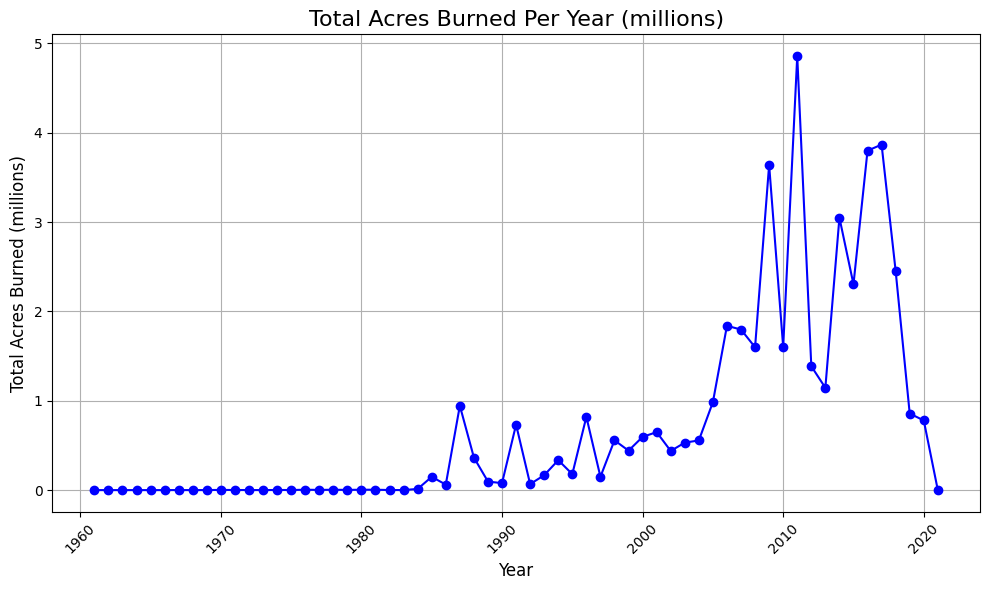

In [20]:
# %%
import matplotlib.pyplot as plt
import pandas as pd
import json

# %%
with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

PER_YEAR_INPUT_PATH = output_paths.get('smoke_impacts_per_year_csv')

# %%
per_year_df = pd.read_csv(PER_YEAR_INPUT_PATH)

# Convert total acres burned to millions
per_year_df['total_acres_burned_millions'] = per_year_df['total_acres_burned'] / 1e6

# %%
# Plotting the time series of total acres burned per year in millions
plt.figure(figsize=(10, 6))

# Plot total acres burned (in millions) against the year
plt.plot(per_year_df['year'], per_year_df['total_acres_burned_millions'], marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Total Acres Burned Per Year (millions)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Acres Burned (millions)', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()
